In [1]:
import gzip
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model

In [2]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset1 = []
for l in f:
    dataset1.append(json.loads(l))

In [3]:
train = dataset1[:180000]
test = dataset1[180000:]

In [4]:
# returns feature vector to run KNN on
def feature_vec(d):
    if 'height' in d:
        h = d['height']
        ft = int(h[0])
        inchs = int(h[3:-1])
        height = ft*12 + inchs
    else:
        height = 63
        
    if 'weight' in d:
        w = d['weight']
        weight = int(w[:-3])
    else:
        weight = 170
    
    return [height, weight, d['size']]

In [5]:
n=434
print(train[n])
print()
print(feature_vec(train[n]))

{'fit': 'small', 'user_id': '907296', 'bust size': '34b', 'item_id': '2248191', 'weight': '135lbs', 'rating': '8', 'rented for': 'work', 'review_text': "The inside of this jacket almost reminds me of a sweatshirt like material...this is super soft and comfortable.  It's not as crisp, stiff or dressy as I thought, and maybe a little bit raggy, but overall I felt it dressed up my jeans and was easy to throw on over a dress for work.  Biggest complaint - I though the 6 would be way too big on me.  It was perfect other than the length...so short!!", 'body type': 'straight & narrow', 'review_summary': 'Comfy and easy way to dress up a casual outfit', 'category': 'jacket', 'height': '5\' 10"', 'size': 12, 'age': '34', 'review_date': 'April 23, 2016'}

[70, 135, 12]


In [6]:
# useful data structures
featuresPerUser = defaultdict()
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
average_weight = 0
average_height = 0

for d in train:
    if 'height' not in d: continue
    if 'weight' not in d: continue
    u = d['user_id']
    i = d['item_id']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)
    featuresPerUser[u] = feature_vec(d)

In [7]:
# returns the distance between two feature vectors
def dist(v1,v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    w = [1,1.2,1.8]
    return np.sqrt(np.sum(np.dot(v1-v2,w)**2))

In [8]:
X_test = [(d['item_id'],feature_vec(d)) for d in test]
y_test = [d['fit'] for d in test]

In [9]:
# return the predicted fit and fit probabilities for a feature vec
def KNN(k, i, x):
    dists = []
    for d in reviewsPerItem[i]:
        u = d['user_id']
        f = featuresPerUser[u]
        dis = dist(x,f)
        dists.append((dis,d['fit']))
    dists.sort()
    
    labels = ["small","fit","large"]
    fits = [0,0,0] # small, fit, large
    for d,fit in dists[:k]:
        if fit == "small":
            fits[0]+=1
        elif fit == "fit":
            fits[1]+=1
        elif fit == "large":
            fits[2]+=1
            
    
    max_idx = fits.index(max(fits))
    if len(dists)==0:
        return "fit", [0,1,0]
    return labels[max_idx], np.array(fits)/min(k,len(dists))
        

In [10]:
def run_KNN(X,k):
    probs_all = []
    preds_all = []
    for p in X:
        i,x = p
        pred, probs = KNN(k, i, x)
        probs_all.append(list(probs))
        preds_all.append(pred)
    return np.array(probs_all), preds_all

In [11]:
y_score, y_pred = run_KNN(X_test,k=6)

In [12]:
print(y_score[:10])

[[0.         1.         0.        ]
 [0.         0.5        0.5       ]
 [0.         0.83333333 0.16666667]
 [0.16666667 0.83333333 0.        ]
 [0.5        0.5        0.        ]
 [0.         0.5        0.5       ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.33333333 0.66666667 0.        ]
 [0.         0.83333333 0.16666667]]


In [13]:
print(y_test[:10])

['fit', 'large', 'fit', 'fit', 'fit', 'large', 'fit', 'fit', 'large', 'fit']


In [14]:
print(y_pred[:10])

['fit', 'fit', 'fit', 'fit', 'small', 'fit', 'fit', 'fit', 'fit', 'fit']


In [15]:
### AUC

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [17]:
y_testb = label_binarize(y_test, classes=['small', 'fit', 'large'])

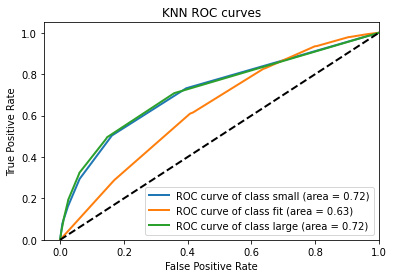

In [18]:
n_classes=3
labels = ["small","fit","large"]
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in [0,1,2]:
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC curves')
plt.legend(loc="lower right")
plt.show()

In [19]:
0.73*(0.63)+0.12*(0.72)+0.13*(0.72)

0.6399